## Titanic: Machine Learning from Disaster

Titanic: Machine Learning from Disaster is a knowledge competition on Kaggle. This is a binary classification problem: the goal is to predict the survival or the death of a given passenger based on a set of variables describing him such as his age, his sex, or his passenger class on the boat.

I have recently achieved an accuracy score of 0.81339 on the public leaderboard. Currently, I am ranked among the top 5% of all Kagglers.

General description and data are available on [Kaggle](https://www.kaggle.com/c/titanic).

1. [Load Dataset](#1)

2. [Feature Engineering](#2)

3. [Correlation Matrix](#3)

4. [Predictive Modeling](#4)

## <a name="1">Load Dataset</a>

In [168]:
import pandas as pd

In [169]:
train_df=pd.read_csv("data/train.csv")
test_df=pd.read_csv("data/test.csv")
data_df=train_df.append(test_df)

In [121]:
data_df.head(2)

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599


## <a name="2">Feature Engineering</a>

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

Let's check if there is any inconsistency in the dataset.

In [10]:
data_df.info() # checking for total null values

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 12 columns):
Age            1046 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Fare           1308 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
dtypes: float64(3), int64(4), object(5)
memory usage: 132.9+ KB


The Age, Cabin and Embarked have null values.

How many survived ?

In [54]:
train_df["Survived"].value_counts()

0    549
1    342
Name: Survived, dtype: int64

Out of 891 passengers in training set, only around 350 survived i.e Only 38.4% of the total training set survived the crash.

Let's check the survival rate by using the different features of the dataset. Some of the features being Sex, Port Of Embarcation, Age,etc.

First let's understand the different types of features.

Types of features:
- Categorical Features: A categorical variable is one that has two or more categories and each value in that feature can be categorised by them. For example, sex is a categorical variable having two categories (male and female). We cannot sort or give any ordering to such variables.
- Ordinal Features: An ordinal variable is similar to categorical values, but the difference between them is that we can have relative ordering or sorting between the values. For example, If we have a feature like Height with values Tall, Medium, Short, then Height is an ordinal variable.
- Continuous Features: A feature is said to be continuous if it can take values between any two points or between the minimum or maximum values in the features column. For example, Age is a continuous feature.

**Title**

In [170]:
data_df["Title"]=data_df["Name"]
# Cleaning name and extracting Title
for name_string in data_df["Name"]:
    data_df["Title"]=data_df["Name"].str.extract("([A-Za-z]+)\.",expand=True)

# Replacing rare titles with more common ones
data_df["Title"].replace(["Mlle","Mme","Ms","Dr","Major","Lady","Countess","Jonkheer","Col","Rev","Capt","Sir","Don","Dona"],
                        ["Miss","Miss","Miss","Mr","Mr","Mrs","Mrs","Other","Other","Other","Mr","Mr","Mr","Mrs"],inplace=True)

**Age -> Continuous Feature**

In [71]:
print("Oldest Passenger was of: {} Years".format(train_df["Age"].max()))
print("Youngest Passenger was of: {} Years".format(train_df["Age"].min()))
print("Average age on the ship: {} Years".format(train_df["Age"].mean()))

Oldest Passenger was of: 80.0 Years
Youngest Passenger was of: 0.42 Years
Average age on the ship: 29.69911764705882 Years


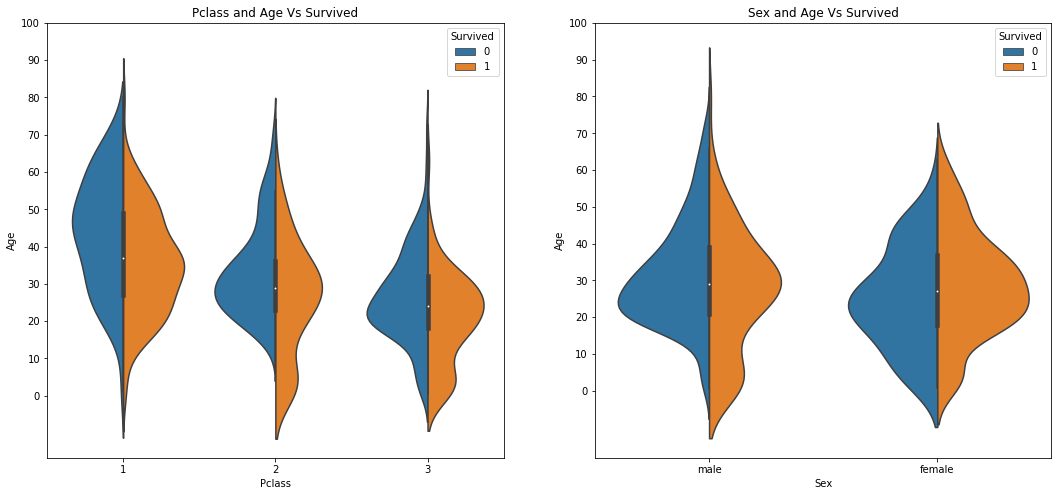

In [72]:
f,ax=plt.subplots(1,2,figsize=(18,8))
sns.violinplot("Pclass","Age",hue="Survived",data=train_df,split=True,ax=ax[0])
ax[0].set_title("Pclass and Age Vs Survived")
ax[0].set_yticks(range(0,110,10))
sns.violinplot("Sex","Age",hue="Survived",data=train_df,split=True,ax=ax[1])
ax[1].set_title("Sex and Age Vs Survived")
ax[1].set_yticks(range(0,110,10))
plt.show()

**Observations**:
- The number of children increases with Pclass and the survival rate for passenegers below Age 10(i.e children) looks to be good irrespective of the Pclass
- Survival chances for Passenegers aged 20-50 from Pclass1 is high and is even better for Women
- For males, the survival chances decreases with an increase in age

As we had seen earlier, the Age feature has 177 null values.

In [82]:
data_df["Title"].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Other'], dtype=object)

In [85]:
# So let's check the average age by Titles
data_df.groupby("Title")["Age"].mean()

Title
Master     5.482642
Miss      21.834533
Mr        32.545531
Mrs       37.046243
Other     44.923077
Name: Age, dtype: float64

Filling NaN Ages

In [171]:
data_df.loc[(data_df.Age.isnull())&(data_df.Title=="Mr"),"Age"]=33
data_df.loc[(data_df.Age.isnull())&(data_df.Title=="Mrs"),"Age"]=36
data_df.loc[(data_df.Age.isnull())&(data_df.Title=="Master"),"Age"]=5
data_df.loc[(data_df.Age.isnull())&(data_df.Title=="Miss"),"Age"]=22
data_df.loc[(data_df.Age.isnull())&(data_df.Title=="Other"),"Age"]=46

In [172]:
data_df["Age"].isnull().any()

False

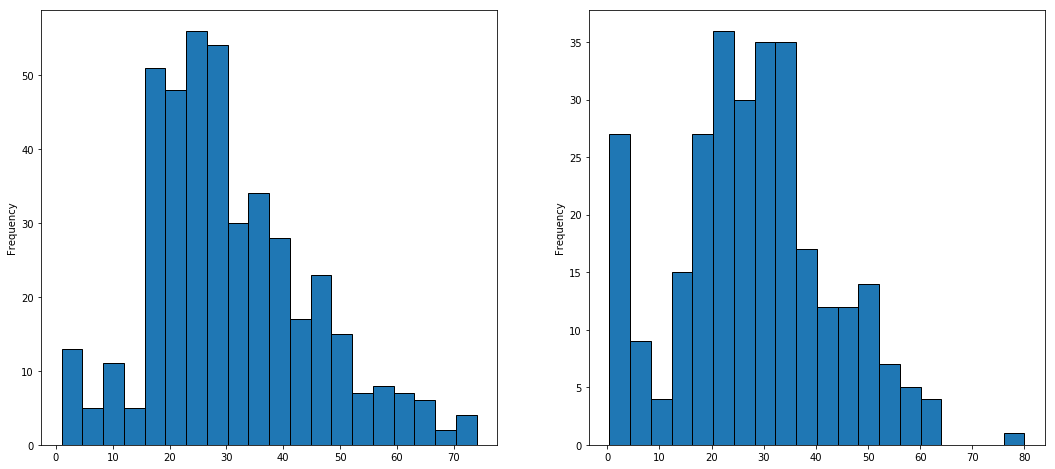

In [105]:
f,ax=plt.subplots(1,2,figsize=(18,8))
train_df[train_df["Survived"]==0]["Age"].plot.hist(ax=ax[0],bins=20,edgecolor="black")
train_df[train_df["Survived"]==1]["Age"].plot.hist(ax=ax[1],bins=20,edgecolor="black")
plt.show()

The babies were saved in large numbers. The women and child first policy. Maximum number of deaths were in the age group of 30-40.

**Age_bins**

In [173]:
from sklearn.preprocessing import LabelEncoder

In [174]:
data_df["AgeBin"]=pd.qcut(data_df["Age"],4)

label=LabelEncoder()
data_df["AgeBin_code"]=label.fit_transform(data_df["AgeBin"])

train_df["AgeBin_code"]=data_df["AgeBin_code"][:891]
test_df["AgeBin_code"]=data_df["AgeBin_code"][891:]

train_df.drop(["Age"],1,inplace=True)
test_df.drop(["Age"],1,inplace=True)

**Embarked--> Categorical Value**

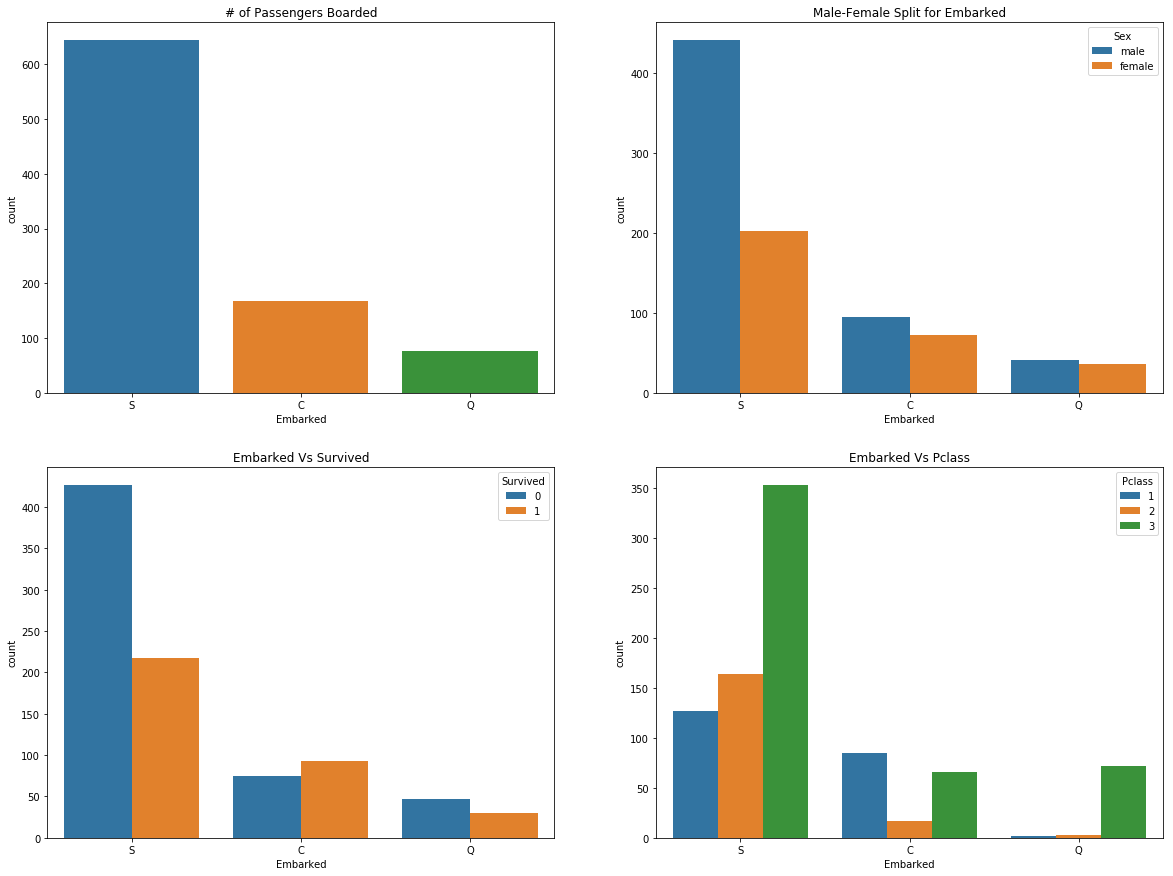

In [96]:
f,ax=plt.subplots(2,2,figsize=(20,15))
sns.countplot("Embarked",data=train_df,ax=ax[0,0])
ax[0,0].set_title("# of Passengers Boarded")
sns.countplot("Embarked",hue="Sex",data=train_df,ax=ax[0,1])
ax[0,1].set_title("Male-Female Split for Embarked")
sns.countplot("Embarked",hue="Survived",data=train_df,ax=ax[1,0])
ax[1,0].set_title("Embarked Vs Survived")
sns.countplot("Embarked",hue="Pclass",data=train_df,ax=ax[1,1])
ax[1,1].set_title("Embarked Vs Pclass")
plt.show()

In [122]:
print(train_df[["Embarked","Survived"]].groupby(["Embarked"],as_index=False).mean())

  Embarked  Survived
0        C  0.553571
1        Q  0.389610
2        S  0.336957


**Observations**:
- Maximum passenegers boarded from S. Majority of them being from Pclass3.
- The Passengers from C look to be lucky as a good proportion of them survived. The reason for this maybe the rescue of all the Pclass1 and Pclass2 Passengers.
- The Embark S looks to the port from where majority of the rich people boarded. Still the chances for survival is low here, that is because many passengers from Pclass3 around 81% didn't survive.
- Port Q had almost 95% of the passengers were from Pclass3.

**Family_size**

In [175]:
data_df["Family_size"]=data_df["Parch"]+data_df["SibSp"]

train_df["Family_size"]=data_df["Family_size"][:891]
test_df["Family_size"]=data_df["Family_size"][891:]

In [118]:
print(train_df[["Family_size","Survived"]].groupby(["Family_size"],as_index=False).mean())

   Family_size  Survived
0            0  0.303538
1            1  0.552795
2            2  0.578431
3            3  0.724138
4            4  0.200000
5            5  0.136364
6            6  0.333333
7            7  0.000000
8           10  0.000000


**Family_survival**

In [180]:
data_df["Last_name"]=data_df["Name"].apply(lambda x: str.split(x,",")[0])
data_df["Fare"].fillna(data_df["Fare"].mean(),inplace=True)

DEFAULT_SURVIVAL_VALUE=0.5
data_df["Family_survival"]=DEFAULT_SURVIVAL_VALUE

for grp,grp_df in data_df[["Survived","Name","Last_name","Fare","Ticket","PassengerId","SibSp","Parch","Age","Cabin"]].groupby(["Last_name","Fare"]):
    
    if(len(grp_df)!=1):
        # A family group is found
        for ind,row in grp_df.iterrows():
            smax=grp_df.drop(ind)["Survived"].max()
            smin=grp_df.drop(ind)["Survived"].min()
            passID=row["PassengerId"]
            if(smax==1.0):
                data_df.loc[data_df["PassengerId"]==passID,"Family_survival"]=1
            elif(smin==0.0):
                data_df.loc[data_df["PassengerId"]==passID,"Family_survival"]=0

print("Number of passengers with family survival information: {}".format(data_df.loc[data_df["Family_survival"]!=0.5].shape[0]))

Number of passengers with family survival information: 420


In [183]:
for _,grp_df in data_df.groupby("Ticket"):
    if(len(grp_df)!=1):
        for ind,row in grp_df.iterrows():
            if(row["Family_survival"]==0)|(row["Family_survival"]==0.5):
                smax=grp_df.drop(ind)["Survived"].max()
                smin=grp_df.drop(ind)["Survived"].min()
                passID=row["PassengerId"]
                if(smax==1.0):
                    data_df.loc[data_df["PassengerId"]==passID,"Family_survival"]=1
                elif(smin==0.0):
                    data_df.loc[data_df["PassengerId"]==passID,"Family_survival"]=0
    
print("Number of passengers with family/group survival information: {}".format(data_df.loc[data_df["Family_survival"]!=0.5].shape[0]))

train_df["Family_survival"]=data_df["Family_survival"][:891]
test_df["Family_survival"]=data_df["Family_survival"][891:]

Number of passengers with family/group survival information: 546


**Fare -> Continuous Feature**

In [98]:
print("Highest Fare was: {}".format(train_df["Fare"].max()))
print("Lowest Fare was: {}".format(train_df["Fare"].min()))
print("Average Fare was: {}".format(train_df["Fare"].mean()))

Highest Fare was: 512.3292
Lowest Fare was: 0.0
Average Fare was: 32.2042079685746


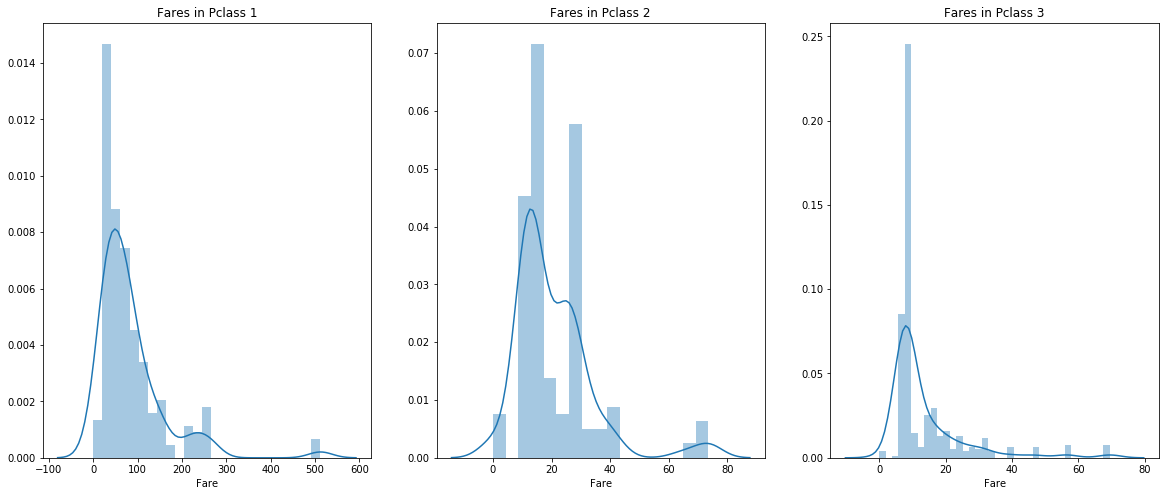

In [100]:
f,ax=plt.subplots(1,3,figsize=(20,8))
sns.distplot(train_df[train_df["Pclass"]==1]["Fare"],ax=ax[0])
ax[0].set_title("Fares in Pclass 1")
sns.distplot(train_df[train_df["Pclass"]==2]["Fare"],ax=ax[1])
ax[1].set_title("Fares in Pclass 2")
sns.distplot(train_df[train_df["Pclass"]==3]["Fare"],ax=ax[2])
ax[2].set_title("Fares in Pclass 3")
plt.show()

There looks to be a large distribution in the fares of Passengers in Pclass1 and this distribution goes on decreasing as the standards reduces. As this is also continous, we can convert into discrete values by using binning.

**Fare_bins**

In [184]:
data_df["Fare"].fillna(data_df["Fare"].median(),inplace=True)

# Making Bins
data_df["FareBin"]=pd.qcut(data_df["Fare"],5)

label=LabelEncoder()
data_df["FareBin_code"]=label.fit_transform(data_df["FareBin"])

train_df["FareBin_code"]=data_df["FareBin_code"][:891]
test_df["FareBin_code"]=data_df["FareBin_code"][891:]

train_df.drop(["Fare"],1,inplace=True)
test_df.drop(["Fare"],1,inplace=True)

**Pclass -> Ordinal Feature**

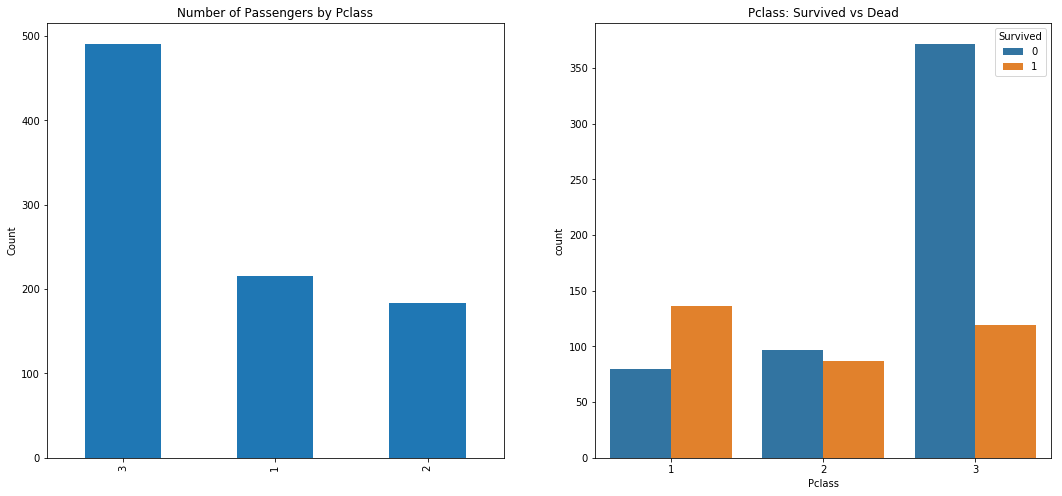

In [64]:
f,ax=plt.subplots(1,2,figsize=(18,8))
train_df["Pclass"].value_counts().plot.bar(ax=ax[0])
ax[0].set_title("Number of Passengers by Pclass")
ax[0].set_ylabel("Count")
sns.countplot("Pclass",hue="Survived",data=train_df,ax=ax[1])
ax[1].set_title("Pclass: Survived Vs Dead")
plt.show()

In [116]:
print(train_df[["Pclass","Survived"]].groupby(["Pclass"],as_index=False).mean())

   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363


We can clearly see that Passenegers Of Pclass 1 were given a very high priority while rescue. Even though the the number of Passengers in Pclass 3 were a lot higher, still the number of survival from them is very low, somewhere around 25%.

For Pclass 1 %survived is around 63% while for Pclass2 is around 48%.

**Mapping Sex and cleaning data**

Sex -> Categorical Feature

In [57]:
train_df.groupby(["Sex","Survived"])["Survived"].count()

Sex     Survived
female  0            81
        1           233
male    0           468
        1           109
Name: Survived, dtype: int64

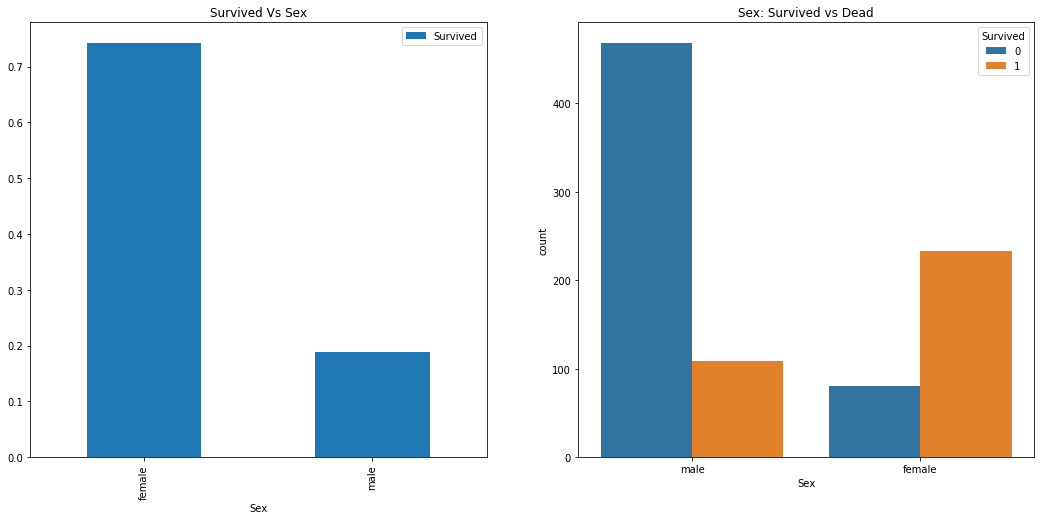

In [60]:
f,ax=plt.subplots(1,2,figsize=(18,8))
train_df[["Sex","Survived"]].groupby(["Sex"]).mean().plot.bar(ax=ax[0])
ax[0].set_title("Survived Vs Sex")
sns.countplot("Sex",hue="Survived",data=train_df,ax=ax[1])
ax[1].set_title("Sex: Survived Vs Dead")
plt.show()

In [117]:
print(train_df[["Sex","Survived"]].groupby(["Sex"],as_index=False).mean())

   Sex  Survived
0    0  0.188908
1    1  0.742038


This looks interesting. The number of men on the ship is lot more than the number of women. Still the number of women saved is almost twice the number of males saved. The survival rates for a women on the ship is around 75% while that for men in around 18-19%.

In [185]:
train_df["Sex"].replace(["male","female"],[0,1],inplace=True)
test_df["Sex"].replace(["male","female"],[0,1],inplace=True)

train_df.drop(["Name","PassengerId","SibSp","Parch","Ticket","Cabin","Embarked"],1,inplace=True)
test_df.drop(["Name","PassengerId","SibSp","Parch","Ticket","Cabin","Embarked"],1,inplace=True)

So now our datasets look like this:

In [186]:
train_df.head(3)

,Survived,Pclass,Sex,AgeBin_code,Family_size,Family_survival,FareBin_code
0,0,3,0,0,1,0.5,0
1,1,1,1,3,1,0.5,4
2,1,3,1,1,0,0.5,1


## <a name="3">Correlation Matrix</a>

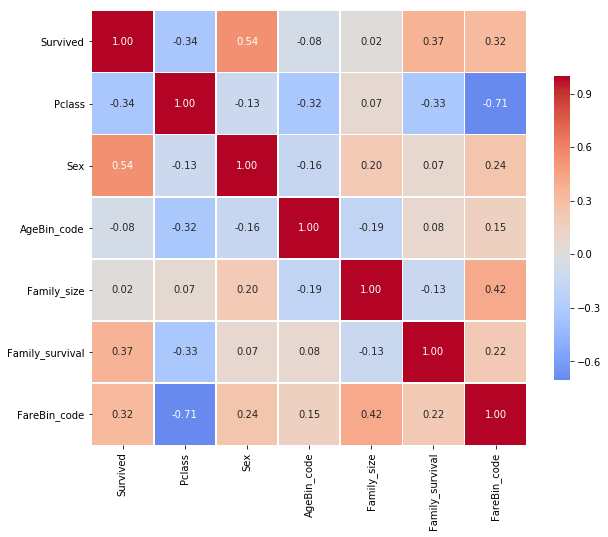

In [187]:
def correlation_heatmap(dataframe):
    correlations=dataframe.corr()
    sns.heatmap(correlations,vmax=1.0,center=0,fmt=".2f",square=True,linewidths=.5,annot=True,cmap="coolwarm",\
               cbar_kws={"shrink":.70})
    fig=plt.gcf()
    fig.set_size_inches(10,8)
    plt.show()

correlation_heatmap(train_df)

## <a name="4">Predictive Modeling</a>

We have gained some insights from the EDA part. But with that, we cannot accurately predict or tell whether a passenger will survive or die. So now we will predict the whether the Passenger will survive or not using some great Classification Algorithms.

**Creating X and y**

In [188]:
X=train_df.drop("Survived",1)
y=train_df["Survived"]
X_test=test_df.copy()

**Scaling features**

In [143]:
from sklearn.preprocessing import StandardScaler

In [189]:
std_scaler=StandardScaler()
X=std_scaler.fit_transform(X)
X_test=std_scaler.fit_transform(X_test)

**Grid Search CV**

Here I use KNN

In [145]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

In [196]:
n_neighbors=list(range(2,21))
algorithm=["auto"]
weights=["uniform","distance"]
leaf_size=list(range(1,50,5))
hyperparams={"algorithm":algorithm,"weights":weights,"leaf_size":leaf_size,"n_neighbors":n_neighbors}
gd=GridSearchCV(estimator=KNeighborsClassifier(),param_grid=hyperparams,verbose=True,cv=10,scoring="roc_auc")
gd.fit(X,y)
print(gd.best_score_)
print(gd.best_estimator_)

Fitting 10 folds for each of 380 candidates, totalling 3800 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.8914655235831708
KNeighborsClassifier(algorithm='auto', leaf_size=16, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=18, p=2,
                     weights='uniform')


[Parallel(n_jobs=1)]: Done 3800 out of 3800 | elapsed:   29.5s finished


**Using a model found by grid searching**

In [197]:
gd.best_estimator_.fit(X,y)
y_pred=gd.best_estimator_.predict(X_test)

**Using another k**

In [193]:
"""clf=KNeighborsClassifier(algorithm='auto', leaf_size=11, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=6, p=2,
                     weights='uniform')
clf.fit(X,y)
y_pred=clf.predict(X_test)"""

**Create csv to upload to Kaggle**

In [198]:
temp=pd.DataFrame(pd.read_csv("data/test.csv")["PassengerId"])
temp["Survived"]=y_pred
temp.to_csv("output/submission.csv",index=False)